# Details of Pango recombinants

This notebook performs the analysis required for the Results/Recombinant pango lineages, primarily in the Long ARG.

In [1]:
import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tskit
import tszip
import sc2ts.utils

In [2]:
%%time
ts = tszip.decompress("../data/upgma-mds-1000-md-30-mm-3-2022-06-30-recinfo2-gisaid-il.ts.tsz")
ts

CPU times: user 1.17 s, sys: 840 ms, total: 2.01 s
Wall time: 1.52 s


In [3]:
ti = sc2ts.utils.TreeInfo(ts)

def report(*args, **kwargs):
    display(*ti.node_report(*args, **kwargs))

ti

Classifying mutations: 100%|██████████| 1062072/1062072 [00:13<00:00, 78331.53it/s]


,value
property,
latest_sample,2022-06-30
max_submission_delay,29 days
samples,657239
nodes,783231
mc_nodes,37749
pr_nodes,34358
re_nodes,2078
recombinants,2078
mutations,1062072


## Compare Nextclade and GISAID assignments

This is slightly tedious, because we need to create a TreeInfo instance based on GISAID to get the pango_lineage_samples out of it.

In [4]:
prev_pangoX = None
for treeinfo, src in zip(
    (ti, sc2ts.utils.TreeInfo(ts, pango_source="GISAID_lineage")),
    ("Nextclade", "GISAID")
):
    print("\n*", src, "Pango designations:")
    x_lineage_names = {lin for lin in treeinfo.pango_lineage_samples.keys() if lin.startswith("X")}
    all_x_samples = [u for lin in x_lineage_names for u in treeinfo.pango_lineage_samples[lin]]
    df = treeinfo.recombinant_samples_report(all_x_samples)
    counts = {lin: len(treeinfo.pango_lineage_samples[lin]) for lin in x_lineage_names}
    counts = {k: counts[k] for k in sorted(counts, key=counts.get, reverse=True) if counts[k] > 0}
    print(
        len(all_x_samples), "PangoX samples from",
        len(counts), "lineages:",
        counts
    )
    recombination_nodes = df.recombinant
    nonsingletons = df[treeinfo.nodes_max_descendant_samples[df.recombinant] > 1]
    print(
        len(nonsingletons), "nonsingleton PangoX samples from",
        len(set(nonsingletons.pango)), "lineages:",
        set(nonsingletons.pango)
    )
    if prev_pangoX is None:
        prev_pangoX = [x_lineage_names, set(nonsingletons.pango)]
    else:
        overlap = x_lineage_names.intersection(prev_pangoX[0])
        overlap_ns = set(nonsingletons.pango).intersection(prev_pangoX[1])
        print("--")
        print(len(overlap), src, "lineages overlap with previous:", overlap)
        print(len(overlap_ns), src, "nonsingleton lineages overlap with previous:", overlap_ns)


Classifying mutations: 100%|██████████| 1062072/1062072 [00:14<00:00, 74054.31it/s]



* Nextclade Pango designations:
749 PangoX samples from 33 lineages: {'XE': 170, 'XZ': 92, 'XN': 69, 'XB': 58, 'XAB': 50, 'XM': 48, 'XAF': 36, 'XG': 32, 'XAC': 27, 'XAG': 17, 'XAH': 14, 'XQ': 14, 'XAJ': 12, 'XH': 11, 'XW': 11, 'XL': 10, 'XAE': 9, 'XR': 8, 'XAA': 8, 'XY': 6, 'XAD': 6, 'XS': 6, 'XK': 6, 'XC': 5, 'XA': 5, 'XD': 4, 'XJ': 3, 'XU': 3, 'XV': 3, 'XF': 2, 'XP': 2, 'XAK': 1, 'XT': 1}
711 nonsingleton PangoX samples from 33 lineages: {'XJ', 'XC', 'XL', 'XAK', 'XA', 'XY', 'XN', 'XZ', 'XAD', 'XD', 'XS', 'XF', 'XAE', 'XAG', 'XP', 'XR', 'XAH', 'XQ', 'XM', 'XAF', 'XG', 'XB', 'XH', 'XE', 'XT', 'XU', 'XV', 'XAJ', 'XAC', 'XAA', 'XW', 'XAB', 'XK'}

* GISAID Pango designations:
515 PangoX samples from 38 lineages: {'XE': 155, 'XB': 56, 'XG': 32, 'XM': 28, 'XAZ': 23, 'XN': 20, 'XAF': 20, 'XAG': 19, 'XAM': 19, 'XH': 11, 'XAC': 11, 'XW': 11, 'XAE': 9, 'XR': 8, 'XAA': 8, 'XL': 7, 'XAP': 7, 'XZ': 7, 'XY': 6, 'XAH': 6, 'XQ': 6, 'XA': 5, 'XAU': 5, 'XAQ': 4, 'XS': 4, 'XAL': 4, 'XAN': 4, 'XAJ': 4,

In [5]:
recombinants = {rec.node: rec for rec in ti.combine_recombinant_info()}

In [6]:
all_x_samples = []
x_lineage_names = {lin for lin in ti.pango_lineage_samples.keys() if lin.startswith("X")}
all_x_samples = [u for lin in x_lineage_names for u in ti.pango_lineage_samples[lin]]
df = ti.recombinant_samples_report(all_x_samples)
df

recombinant  direct  path_length    node   
0         625355   False            1  691173  \
1         701594    True            1  701593   
2         741659    True            1  741658   
3         251176    True            1  251175   
4         292030    True            1  292029   
..           ...     ...          ...     ...   
744       653674    True            1  653673   
745       676545    True            1  676544   
746       751632    True            2  751631   
747       751632   False            3  764461   
748       751632   False            4  776053   

                                  strain pango  parents  children   
0    Botswana/R1113B92_BHP_AAC81766/2022    XJ        1         0  \
1           Slovakia/TN_22_00001346/2022    XJ        1         0   
2             USA/TX-HMH-MCoV-99411/2022    XJ        1         0   
3              USA/MA-CDC-LC0040918/2021    XC        1         2   
4              USA/WV-CDC-LC0059910/2021    XC        1         2   
..                                   ...   ...      ...       ...   
744         Germany/ST-RKI-I-696000/2022    XK        1         0   
745      Belgium/AZDelta-2213-04678/2022    XK        1         0   
746            USA/WA-CDC-LC0695900/2022    XK        1         0   
747          USA/CA-CDC-QDX38089892/2022    XK        1         1   
748        USA/CA-HLX-STM-DRGNB7VQM/2022    XK        1         0   

     descendants       date   delay    qc  mutations  reversions   
0              1 2022-04-13 10 days  1000          8           1  \
1              1 2022-04-22 12 days  1000          4           0   
2              1 2022-05-26 18 days  0000          3           0   
3              2 2021-04-10 12 days  1000          8           2   
4              4 2021-05-13 14 days  1000          5           4   
..           ...        ...     ...   ...        ...         ...   
744            1 2022-03-11 27 days  0000         16           1   
745            1 2022-03-31  7 days  0000          0           0   
746            1 2022-06-03 27 days  0000          4           0   
747            2 2022-06-14 21 days  0000          5           0   
748            1 2022-06-24 20 days  0000          1           0   

     immediate_reversions  child_mutations  child_reversions  
0                       0                0                 0  
1                       0                0                 0  
2                       0                0                 0  
3                       0                0                 0  
4                       0               14                 3  
..                    ...              ...               ...  
744                     0                0                 0  
745                     0                0                 0  
746                     0                0                 0  
747                     0                1                 0  
748                     0                0                 0  

[749 rows x 17 columns]

# Filter out singleton nodes

In [7]:
recombination_nodes = df.recombinant.unique()
recombination_nodes

array([625355, 701594, 741659, 251176, 292030, 322219, 363172, 638141,
       555388, 172374, 677584, 615119, 668317, 674332, 677977, 700575,
       703379, 731665, 623997, 628656, 636903, 641595, 648753, 651744,
       676531, 693927, 697157, 697596, 704521, 705521, 716084, 746741,
       756841, 649001, 573905, 638775, 589269, 636566, 676648, 588841,
       701181, 635896,     -1, 639472, 674321, 729963, 666230, 696838,
       739545, 640831, 642277, 711560, 733196, 611036, 582054, 609881,
       206466, 285181, 394059, 621567, 629086, 642711, 674229, 687046,
       699692, 705501, 729195, 749143, 756466, 637876, 630214, 638733,
       752475, 722544, 745522, 749460, 731513, 774725, 682411, 663539,
       633497, 663092, 679355, 699376, 733742, 738307, 630235, 653674,
       676545, 751632])

In [8]:
sum(recombination_nodes == -1)

1

There is one sample that has no recombinants in its history (an XP sample; see elsewhere for discussion). Remove this.

In [9]:
recombination_nodes = recombination_nodes[recombination_nodes >= 0]
recombination_nodes

array([625355, 701594, 741659, 251176, 292030, 322219, 363172, 638141,
       555388, 172374, 677584, 615119, 668317, 674332, 677977, 700575,
       703379, 731665, 623997, 628656, 636903, 641595, 648753, 651744,
       676531, 693927, 697157, 697596, 704521, 705521, 716084, 746741,
       756841, 649001, 573905, 638775, 589269, 636566, 676648, 588841,
       701181, 635896, 639472, 674321, 729963, 666230, 696838, 739545,
       640831, 642277, 711560, 733196, 611036, 582054, 609881, 206466,
       285181, 394059, 621567, 629086, 642711, 674229, 687046, 699692,
       705501, 729195, 749143, 756466, 637876, 630214, 638733, 752475,
       722544, 745522, 749460, 731513, 774725, 682411, 663539, 633497,
       663092, 679355, 699376, 733742, 738307, 630235, 653674, 676545,
       751632])

In [10]:
ti.nodes_max_descendant_samples[recombination_nodes]

array([     3,      2,      1,      6,      4,      1,      1,     13,
       127227,      5,      7,      1,      2,      2,      1,      1,
            7,      3,      1,     13,      2,     73,      1,      1,
            2,      3,      1,      1,      1,      1,      1,      1,
            1,      4,      3,      3,      1,      4,      1,      2,
            9,     67,     19,      1,      2,      1,      2,      1,
            2,     40,      1,      4,      1,     51,     33,     68,
            8,      1,    155,      2,      1,      1,      3,      2,
            1,      1,      1,      1,      5,      9,      1,      1,
           13,      5,      2,      2,      1,     27,     13,      1,
            2,      3,     19,      1,      2,      1,      1,      1,
            3], dtype=int32)

In [11]:
singleton_recombination_nodes = recombination_nodes[ti.nodes_max_descendant_samples[recombination_nodes] == 1]
singleton_recombination_nodes

array([741659, 322219, 363172, 615119, 677977, 700575, 623997, 648753,
       651744, 697157, 697596, 704521, 705521, 716084, 746741, 756841,
       589269, 676648, 674321, 666230, 739545, 711560, 611036, 394059,
       642711, 674229, 705501, 729195, 749143, 756466, 638733, 752475,
       774725, 633497, 733742, 630235, 653674, 676545])

In [12]:
singleton_recombination_nodes.shape

(38,)

In [13]:
df_singleton = df[df.recombinant.isin(singleton_recombination_nodes)]
print("Singleton recombinants that are normally removed")
df_singleton

Singleton recombinants that are normally removed


recombinant  direct  path_length    node   
2         741659    True            1  741658  \
6         322219    True            1  322218   
7         363172    True            1  363171   
30        615119    True            1  615118   
47        677977    True            1  677976   
59        700575    True            1  700574   
100       623997    True            1  623996   
105       648753    True            1  648752   
107       651744    True            1  651743   
125       697157    True            1  697156   
126       697596    True            1  697595   
139       704521    True            1  704520   
141       705521    True            1  705520   
151       716084    True            1  716083   
173       746741    True            1  746740   
182       756841    True            1  756840   
201       589269    True            1  589268   
206       676648    True            1  676647   
246       674321    True            1  674320   
263       666230    True            1  666229   
270       739545    True            1  739544   
301       711560    True            1  711559   
321       611036    True            1  611035   
443       394059    True            1  394058   
470       642711    True            1  642710   
525       674229    True            1  674228   
576       705501    True            1  705500   
606       729195    True            1  729194   
617       749143    True            1  749142   
620       756466    True            1  756465   
633       638733    True            1  638732   
634       752475    True            1  752474   
644       774725    True            1  774724   
693       633497    True            1  633496   
720       733742    True            1  733741   
743       630235    True            1  630234   
744       653674    True            1  653673   
745       676545    True            1  676544   

                                     strain pango  parents  children   
2                USA/TX-HMH-MCoV-99411/2022    XJ        1         0  \
6                 USA/NC-CDC-LC0070730/2021    XC        1         0   
7                    Sweden/4088533864/2021    XC        1         0   
30                England/DHSC-CYNKD4G/2022    XN        1         0   
47             Germany/NW-RKI-I-715339/2022    XN        1         0   
59   Lithuania/LTU000_NVSPL_KN_MB26508/2022    XN        1         0   
100               England/MILK-36C3556/2022    XZ        1         0   
105                 Australia/VIC45939/2022    XZ        1         0   
107                 Australia/VIC46095/2022    XZ        1         0   
125              Scotland/QEUH-3D91BEF/2022    XZ        1         0   
126                      Croatia/35852/2022    XZ        1         0   
139               USA/CT-CDC-LC0592034/2022    XZ        1         0   
141               USA/NY-CDC-LC0600401/2022    XZ        1         0   
151     Netherlands/NB-MVD-CWGS2202162/2022    XZ        1         0   
173            Germany/ST-RKI-I-853344/2022    XZ        1         0   
182            Germany/MV-RKI-I-873958/2022    XZ        1         0   
201                  USA/AZ-ASPHL-0290/2022    XS        1         0   
206                 Peru/LIM-INS-16397/2022    XS        1         0   
246              USA/WA-UW-22032991896/2022   XAH        1         0   
263       Switzerland/GR-ETHZ-36911272/2022    XQ        1         0   
270     SouthAfrica/CERI-KRISP-K043514/2022    XQ        1         0   
301               England/LSPA-3DED05E/2022    XM        1         0   
321                  Sweden/SUS0009442/2022   XAF        1         0   
443         USA/NY-PRL-2021_0809_00K06/2021    XB        1         0   
470            Germany/SN-RKI-I-631490/2022    XE        1         0   
525             Canada/QC-L00457188001/2022    XE        1         0   
576               USA/WA-CDC-LC0602400/2022    XE        1         0   
606               Israel/ICH-741225468/2022    XE        1         0   
617  

In [14]:
collections.Counter(df_singleton.pango).most_common(100)

[('XZ', 10),
 ('XE', 6),
 ('XN', 3),
 ('XK', 3),
 ('XC', 2),
 ('XS', 2),
 ('XQ', 2),
 ('XV', 2),
 ('XAB', 2),
 ('XJ', 1),
 ('XAH', 1),
 ('XM', 1),
 ('XAH', 1),
 ('XAF', 1),
 ('XB', 1),
 ('XAJ', 1)]

In [15]:
recombination_nodes = recombination_nodes[ti.nodes_max_descendant_samples[recombination_nodes] > 1]
recombination_nodes

array([625355, 701594, 251176, 292030, 638141, 555388, 172374, 677584,
       668317, 674332, 703379, 731665, 628656, 636903, 641595, 676531,
       693927, 649001, 573905, 638775, 636566, 588841, 701181, 635896,
       639472, 729963, 696838, 640831, 642277, 733196, 582054, 609881,
       206466, 285181, 621567, 629086, 687046, 699692, 637876, 630214,
       722544, 745522, 749460, 731513, 682411, 663539, 663092, 679355,
       699376, 738307, 751632])

# Artefactual recombinant

In [16]:
recombination_nodes[ti.nodes_max_descendant_samples[recombination_nodes] > 1000]

array([555388])

In [17]:
u = 555388
recombinants[u]

Recombinant(causal_strain='Denmark/DCGC-281594/2021', causal_date='2021-12-14', causal_lineage='BA.2.9', hmm_runs={'backward': HmmRun(breakpoints=[0, 22674, 26060, 29904], parents=[544948, 551092, 544948], parent_imputed_lineages=['BA.3', 'BA.1.17', 'BA.3'], mutations=['832T>C', '2790C>T', '9344C>T', '9424A>G', '9866C>T', '10198C>T', '11124T>C', '11235T>C', '17410C>T', '19955C>T', '20055A>G', '21618C>T', '21846T>C', '22200T>G', '22688A>G', '22775G>A', '22786A>C', '22792C>T', '22898A>G', '23048A>G', '23202A>C', '24130A>C', '25624C>T', '27382G>C', '27383A>T', '27384T>C']), 'forward': HmmRun(breakpoints=[0, 22674, 26060, 29904], parents=[544948, 551092, 544948], parent_imputed_lineages=['BA.3', 'BA.1.17', 'BA.3'], mutations=['832T>C', '2790C>T', '9344C>T', '9424A>G', '9866C>T', '10198C>T', '11124T>C', '11235T>C', '17410C>T', '19955C>T', '20055A>G', '21618C>T', '21846T>C', '22200T>G', '22688A>G', '22775G>A', '22786A>C', '22792C>T', '22898A>G', '23048A>G', '23202A>C', '24130A>C', '25624C>T'

In [18]:
df_dodgy = df[df.recombinant == u]
df_dodgy

,recombinant,direct,path_length,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions
18,555388,False,13,759824,Germany/NW-RKI-I-869356/2022,XAK,1,0,1,2022-06-10,11 days,0000,13,4,0,0,0
31,555388,False,14,633031,Sweden/22-534291/2022,XN,1,0,1,2022-02-21,23 days,0000,6,4,0,0,0
32,555388,False,11,658020,Wales/PHWC-PJMO3R/2022,XN,1,1,14,2022-03-15,20 days,0000,2,0,0,1,1
33,555388,False,13,661519,England/LSPA-3B4F8CD/2022,XN,1,0,1,2022-03-18,7 days,0000,0,0,0,0,0
34,555388,False,12,661708,England/PHEP-YYR1B75/2022,XN,1,0,1,2022-03-18,17 days,0000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,555388,False,20,731133,USA/LA-TUSOM-220520_S19/2022,XAJ,1,0,1,2022-05-17,7 days,1000,5,3,0,0,0
641,555388,False,19,758379,England/LSPA-3E52D89/2022,XAJ,1,1,2,2022-06-09,8 days,0000,1,0,0,0,0
642,555388,False,20,770189,England/PHEC-YYFS1MG/2022,XAJ,1,0,1,2022-06-19,19 days,0000,8,5,0,0,0
645,555388,False,20,782398,England/LSPA-3EAC5B5/2022,XAJ,1,0,1,2022-06-30,7 days,0000,0,0,0,0,0


In [19]:
collections.Counter(df_dodgy.pango).most_common(100)

[('XN', 53),
 ('XZ', 16),
 ('XAJ', 6),
 ('XAK', 1),
 ('XAD', 1),
 ('XAH', 1),
 ('XE', 1)]

In [20]:
df_dodgy[df.pango == "XN"]

/var/folders/00/l36df9q14hv13hhw8wglncch0000gr/T/ipykernel_72934/4281046691.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_dodgy[df.pango == "XN"]


,recombinant,direct,path_length,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions
31,555388,False,14,633031,Sweden/22-534291/2022,XN,1,0,1,2022-02-21,23 days,0000,6,4,0,0,0
32,555388,False,11,658020,Wales/PHWC-PJMO3R/2022,XN,1,1,14,2022-03-15,20 days,0000,2,0,0,1,1
33,555388,False,13,661519,England/LSPA-3B4F8CD/2022,XN,1,0,1,2022-03-18,7 days,0000,0,0,0,0,0
34,555388,False,12,661708,England/PHEP-YYR1B75/2022,XN,1,0,1,2022-03-18,17 days,0000,0,0,0,0,0
35,555388,False,13,663859,England/LSPA-3B85DAE/2022,XN,1,0,1,2022-03-20,6 days,0000,1,0,0,0,0
36,555388,False,12,665033,France/NAQ-HCL722001578401/2022,XN,1,0,1,2022-03-21,17 days,0000,3,0,0,0,0
38,555388,False,13,669234,England/LSPA-3C75CA3/2022,XN,1,0,1,2022-03-25,7 days,0000,0,0,0,0,0
39,555388,False,13,669235,England/PHEP-YYRA3Y1/2022,XN,1,0,1,2022-03-25,26 days,0000,1,0,0,0,0
40,555388,False,11,671136,England/LSPA-3CA0762/2022,XN,1,1,2,2022-03-26,8 days,0000,1,0,0,3,0
41,555388,False,11,672929,England/LSPA-3CD3942/2022,XN,1,1,2,2022-03-28,8 days,0000,1,0,0,1,0


In [21]:
recombination_nodes = recombination_nodes[ti.nodes_max_descendant_samples[recombination_nodes] < 1000]
recombination_nodes

array([625355, 701594, 251176, 292030, 638141, 172374, 677584, 668317,
       674332, 703379, 731665, 628656, 636903, 641595, 676531, 693927,
       649001, 573905, 638775, 636566, 588841, 701181, 635896, 639472,
       729963, 696838, 640831, 642277, 733196, 582054, 609881, 206466,
       285181, 621567, 629086, 687046, 699692, 637876, 630214, 722544,
       745522, 749460, 731513, 682411, 663539, 663092, 679355, 699376,
       738307, 751632])

In [22]:
dfx = df[df.recombinant.isin(recombination_nodes)]
dfx

,recombinant,direct,path_length,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions
0,625355,False,1,691173,Botswana/R1113B92_BHP_AAC81766/2022,XJ,1,0,1,2022-04-13,10 days,1000,8,1,0,0,0
1,701594,True,1,701593,Slovakia/TN_22_00001346/2022,XJ,1,0,1,2022-04-22,12 days,1000,4,0,0,0,0
3,251176,True,1,251175,USA/MA-CDC-LC0040918/2021,XC,1,2,2,2021-04-10,12 days,1000,8,2,0,0,0
4,292030,True,1,292029,USA/WV-CDC-LC0059910/2021,XC,1,2,4,2021-05-13,14 days,1000,5,4,0,14,3
5,292030,False,2,298415,USA/PA-CDC-LC0064934/2021,XC,1,1,2,2021-05-18,16 days,0000,14,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,699376,False,1,774790,Mexico/TAB-INMEGEN-78-112/2022,XAB,1,0,1,2022-06-23,16 days,0000,4,0,0,0,0
742,635896,False,3,780516,Italy/CAM-TIGEM-IZSM-COLLI-31979/2022,XAB,1,0,1,2022-06-28,15 days,0000,4,0,0,0,0
746,751632,True,2,751631,USA/WA-CDC-LC0695900/2022,XK,1,0,1,2022-06-03,27 days,0000,4,0,0,0,0
747,751632,False,3,764461,USA/CA-CDC-QDX38089892/2022,XK,1,1,2,2022-06-14,21 days,0000,5,0,0,1,0


In [23]:
len(dfx)

630

In [24]:
filtered_lineage_sample_count = collections.Counter(dfx.pango)
print(f"After filtering, {len(np.unique(dfx.pango))} X lineages remain:", np.unique(dfx.pango))

After filtering, 31 X lineages remain: ['XA' 'XAA' 'XAB' 'XAC' 'XAD' 'XAE' 'XAF' 'XAG' 'XAH' 'XAJ' 'XB' 'XC' 'XD'
 'XE' 'XF' 'XG' 'XH' 'XJ' 'XK' 'XL' 'XM' 'XN' 'XQ' 'XR' 'XS' 'XT' 'XU'
 'XV' 'XW' 'XY' 'XZ']


A table summarising all the remaining Pango recombinants

In [25]:
def get_samples(u, ts):
    """
    Returns all the samples under the specified node.
    """
    samples = set()
    for tree in ts.trees():
        samples |= set(tree.samples(u))
    return samples

def get_sample_composition(u, ts, source="Nextclade_pango"):
    """
    Returns a Counter of the pango lineages descending from the specified node.
    """
    samples = set()
    for tree in ts.trees():
        samples |= set(tree.samples(u))
    return collections.Counter(ts.node(v).metadata[source] for v in samples)


# test it
print(get_samples(172374, ts))
print(get_sample_composition(172374, ts))

{182624, 227648, 228656, 172373, 221655}
Counter({'XA': 5})


In [26]:
lineage_re_nodes = collections.defaultdict(set)
for _, row in dfx.iterrows():
    lineage_re_nodes[row.pango].add(row.recombinant)
lineage_re_nodes

defaultdict(set,
            {'XJ': {625355, 701594},
             'XC': {251176, 292030},
             'XL': {638141},
             'XA': {172374},
             'XY': {677584},
             'XN': {668317, 674332, 703379, 731665},
             'XZ': {628656, 636903, 641595, 676531, 693927},
             'XAD': {641595, 649001},
             'XD': {573905, 638775},
             'XS': {636566},
             'XF': {588841},
             'XAE': {701181},
             'XAG': {635896},
             'XR': {639472},
             'XAH': {641595, 729963},
             'XQ': {635896, 639472, 696838},
             'XM': {625355, 640831, 642277, 733196},
             'XAF': {582054, 677584},
             'XG': {609881},
             'XB': {206466, 285181},
             'XH': {582054},
             'XE': {582054, 621567, 629086, 687046, 699692},
             'XT': {637876},
             'XU': {635896, 638141, 696838},
             'XV': {630214},
             'XAJ': {722544, 731513, 745522, 749460},

Summarize all of the X-lineages

In [27]:
# Taken from https://github.com/cov-lineages/pango-designation/blob/master/pango_designation/alias_key.json
pango_x_aliases = {
    "XA": ["B.1.1.7","B.1.177"],
    "XB": ["B.1.634","B.1.631"],
    "XC": ["AY.29","B.1.1.7"],
    "XD": ["B.1.617.2*","BA.1*"],
    "XE": ["BA.1*","BA.2*"],
    "XF": ["B.1.617.2*","BA.1*"],
    "XG": ["BA.1*","BA.2*"],
    "XH": ["BA.1*","BA.2*"],
    "XJ": ["BA.1*","BA.2*"],
    "XK": ["BA.1*","BA.2*"],
    "XL": ["BA.1*","BA.2*"],
    "XM": ["BA.1.1*","BA.2*"],
    "XN": ["BA.1*","BA.2*"],
    "XP": ["BA.1.1*","BA.2*"],
    "XQ": ["BA.1.1*","BA.2*"],
    "XR": ["BA.1.1*","BA.2*"],
    "XS": ["B.1.617.2*","BA.1.1*"],
    "XT": ["BA.2*","BA.1*"],
    "XU": ["BA.1*","BA.2*"],
    "XV": ["BA.1*","BA.2*"],
    "XW": ["BA.1*","BA.2*"],
    "XY": ["BA.1*","BA.2*"],
    "XZ": ["BA.2*","BA.1*"],
    "XAA": ["BA.1*","BA.2*"],
    "XAB": ["BA.1*","BA.2*"],
    "XAC": ["BA.2*","BA.1*","BA.2*"],
    "XAD": ["BA.2*","BA.1*"],
    "XAE": ["BA.2*","BA.1*"],
    "XAF": ["BA.1*","BA.2*"],
    "XAG": ["BA.1*","BA.2*"],
    "XAH": ["BA.2*","BA.1*"],
    "XAJ": ["BA.2.12.1*","BA.4*"],
    "XAK": ["BA.2*","BA.1*","BA.2*"],
    "XAL": ["BA.1*","BA.2*"],
    "XAM": ["BA.1.1","BA.2.9"],
    "XAN": ["BA.2*","BA.5.1"],
    "XAP": ["BA.2*","BA.1*"],
    "XAQ": ["BA.1*","BA.2*"],
    "XAR": ["BA.1*","BA.2*"],
    "XAS": ["BA.5*","BA.2*"],
    "XAT": ["BA.2.3.13","BA.1*"],
    "XAU": ["BA.1.1*","BA.2.9*"],
    "XAV": ["BA.2*","BA.5*"],
    "XAW": ["BA.2*","AY.122"],
    "XAY": ["BA.2*","AY.45","BA.2*","AY.45","BA.2*"],
    "XAZ": ["BA.2.5","BA.5","BA.2.5"],
    "XBA": ["BA.2*","AY.45","BA.2*","AY.45","BA.2*"],
    "XBB": ["BJ.1","BM.1.1.1"],
    "XBC": ["BA.2*","B.1.617.2*","BA.2*","B.1.617.2*"],
    "XBD": ["BA.2.75.2","BF.5"],
    "XBE": ["BA.5.2","BE.4.1"],
    "XBF": ["BA.5.2.3","CJ.1"],
    "XBG": ["BA.2.76","BA.5.2"],
    "XBH": ["BA.2.3.17","BA.2.75.2"],
    "XBJ": ["BA.2.3.20","BA.5.2"],
    "XBK": ["BA.5.2","CJ.1"],
    "XBL": ["XBB.1","BA.2.75","XBB.1"],
    "XBM": ["BA.2.76","BF.3"],
    "XBN": ["BA.2.75","XBB.3"],
    "XBP": ["BA.2.75*","BQ.1*"],
    "XBQ": ["BA.5.2","CJ.1"],
    "XBR": ["BA.2.75","BQ.1"],
    "XBS": ["BA.2.75","BQ.1"],
    "XBT": ["BA.5.2.34","BA.2.75","BA.5.2.34"],
    "XBU": ["BA.2.75.3","BQ.1","BA.2.75.3"],
    "XBV": ["CR.1","XBB.1"],
    "XBW": ["XBB.1.5","BQ.1.14"],
    "XBY": ["BR.2.1","XBF"],
    "XBZ": ["BA.5.2*","EF.1.3"],
    "XCA": ["BA.2.75*","BQ.1*"]
}

In [28]:
data = []
# the nonsingleton ts will have the same node numbers, but
# singleton recombinants won't be marked as samples
nonsingleton_ts = sc2ts.utils.detach_singleton_recombinants(ts)

for lin, nodes in lineage_re_nodes.items():
    X_descendants = []
    samples = []
    sample_counts = []
    nodes = sorted(nodes)  # sort by time, oldest first
    for node in nodes:
        samples.append(list(get_samples(node, nonsingleton_ts)))
        node_pango = get_sample_composition(node, nonsingleton_ts)
        X_descendants.append(node_pango[lin])
        sample_counts.append(node_pango)
    X_descendants = np.array(X_descendants)
    others = "No main clade"
    sc2ts_parents = "No main clade"
    muts = "-"
    if (X_descendants == max(X_descendants)).sum() == 1:
        # has a single "main" clade with the highest number of `lin` samples
        main_clade_sample_counts = sample_counts[np.argmax(X_descendants)]
        rec = recombinants[nodes[np.argmax(X_descendants)]]
        others = ", ".join(f"{k}: {v}{'/' + str(filtered_lineage_sample_count[k]) if filtered_lineage_sample_count[k] > 0 else ''}"
                           for k, v in main_clade_sample_counts.items() if k != lin)
        sc2ts_parents = " + ".join(k.replace(" (R)", "") for k in sorted(set(rec.arg_info.parent_imputed_lineages)))
        num_origins = ', '.join(f"\\textbf{{{x}}}" if x == X_descendants.max() else f"{x}" for x in X_descendants)
        muts = (nonsingleton_ts.mutations_node == nodes[np.argmax(X_descendants)]).sum()
    else:
        num_origins = ', '.join(f"{x}" for x in X_descendants)
    if len(nodes) > 1:
        num_origins = f"{filtered_lineage_sample_count[lin]} ({num_origins})"
    if len(np.concatenate(samples)) > len(np.unique(np.concatenate(samples))):
        num_origins += "*"
    row = {"Focal Pango": lin,
           "nchar_Pango": len(lin), # Only for sorting
           "Num origins": len(nodes),
           "Num focal samples (further split by origin, *=nested)": num_origins, 
           "Official Pango parents": " + ".join(sorted(set(pango_x_aliases[lin]))),
           "\\textbf{Main clade}: sc2ts parents": sc2ts_parents, 
           "\\textbf{Main clade}: additional descendants": others,
           "muts": muts,
          }
          # **rec.data_summary()}
    data.append(row)
df_summary = pd.DataFrame(data).sort_values(
        ["Num origins", "nchar_Pango", "Focal Pango"]).drop(
            columns=["nchar_Pango"]).set_index("Focal Pango")
df_summary

,Num origins,"Num focal samples (further split by origin, *=nested)",Official Pango parents,\textbf{Main clade}: sc2ts parents,\textbf{Main clade}: additional descendants,muts
Focal Pango,,,,,,
XA,1,\textbf{5},B.1.1.7 + B.1.177,B.1.1.7 + B.1.177.18,,0
XF,1,\textbf{2},B.1.617.2* + BA.1*,AY.4 + BA.1,,0
XG,1,\textbf{32},BA.1* + BA.2*,BA.1.17 + BA.2,XAB: 1/48,0
XH,1,\textbf{11},BA.1* + BA.2*,BA.1.20 + BA.2.9,"XAF: 34/35, B.1.1.529: 2, XE: 3/163",0
XK,1,\textbf{3},BA.1* + BA.2*,BA.1.1.1 + BA.2,,0
XL,1,\textbf{10},BA.1* + BA.2*,BA.1.17.2 + BA.2,"XAB: 1/48, XU: 1/3",0
XR,1,\textbf{8},BA.1.1* + BA.2*,BA.1.1 + BA.2,"XQ: 9/12, XAB: 2/48",0
XS,1,\textbf{4},B.1.617.2* + BA.1.1*,AY.36 + BA.1.1,,3
XT,1,\textbf{1},BA.1* + BA.2*,BA.2.23 + Unknown,BA.2.23: 1,2


In [29]:
print(df_summary.style.applymap_index(
    lambda v: "font-weight: bold;", axis="rows"
).to_latex(convert_css=True, hrules=True))

\begin{tabular}{lrlllll}
\toprule
 & Num origins & Num focal samples (further split by origin, *=nested) & Official Pango parents & \textbf{Main clade}: sc2ts parents & \textbf{Main clade}: additional descendants & muts \\
Focal Pango &  &  &  &  &  &  \\
\midrule
\bfseries XA & 1 & \textbf{5} & B.1.1.7 + B.1.177 & B.1.1.7 + B.1.177.18 &  & 0 \\
\bfseries XF & 1 & \textbf{2} & B.1.617.2* + BA.1* & AY.4 + BA.1 &  & 0 \\
\bfseries XG & 1 & \textbf{32} & BA.1* + BA.2* & BA.1.17 + BA.2 & XAB: 1/48 & 0 \\
\bfseries XH & 1 & \textbf{11} & BA.1* + BA.2* & BA.1.20 + BA.2.9 & XAF: 34/35, B.1.1.529: 2, XE: 3/163 & 0 \\
\bfseries XK & 1 & \textbf{3} & BA.1* + BA.2* & BA.1.1.1 + BA.2 &  & 0 \\
\bfseries XL & 1 & \textbf{10} & BA.1* + BA.2* & BA.1.17.2 + BA.2 & XAB: 1/48, XU: 1/3 & 0 \\
\bfseries XR & 1 & \textbf{8} & BA.1.1* + BA.2* & BA.1.1 + BA.2 & XQ: 9/12, XAB: 2/48 & 0 \\
\bfseries XS & 1 & \textbf{4} & B.1.617.2* + BA.1.1* & AY.36 + BA.1.1 &  & 3 \\
\bfseries XT & 1 & \textbf{1} & BA.1* + BA

In [30]:
print(
    (df_summary['Num origins']==1).sum(),
    "single origin pango X lineages"
)

16 single origin pango X lineages


# Single origin pango x lineages

Where all of the samples in the X lineage trace back to the same recombination node.



In [31]:
lineage_re_nodes = collections.defaultdict(set)
for _, row in dfx.iterrows():
    lineage_re_nodes[row.pango].add(row.recombinant)
lineage_re_nodes

defaultdict(set,
            {'XJ': {625355, 701594},
             'XC': {251176, 292030},
             'XL': {638141},
             'XA': {172374},
             'XY': {677584},
             'XN': {668317, 674332, 703379, 731665},
             'XZ': {628656, 636903, 641595, 676531, 693927},
             'XAD': {641595, 649001},
             'XD': {573905, 638775},
             'XS': {636566},
             'XF': {588841},
             'XAE': {701181},
             'XAG': {635896},
             'XR': {639472},
             'XAH': {641595, 729963},
             'XQ': {635896, 639472, 696838},
             'XM': {625355, 640831, 642277, 733196},
             'XAF': {582054, 677584},
             'XG': {609881},
             'XB': {206466, 285181},
             'XH': {582054},
             'XE': {582054, 621567, 629086, 687046, 699692},
             'XT': {637876},
             'XU': {635896, 638141, 696838},
             'XV': {630214},
             'XAJ': {722544, 731513, 745522, 749460},

In [32]:
all_re_nodes = set()
for nodes in lineage_re_nodes.values():
    all_re_nodes|= nodes
len(all_re_nodes)

50

In [33]:
single_origin_lineages = {lin: list(nodes)[0] for lin, nodes in lineage_re_nodes.items() if len(nodes) == 1}
single_origin_lineages 

{'XL': 638141,
 'XA': 172374,
 'XY': 677584,
 'XS': 636566,
 'XF': 588841,
 'XAE': 701181,
 'XAG': 635896,
 'XR': 639472,
 'XG': 609881,
 'XH': 582054,
 'XT': 637876,
 'XV': 630214,
 'XAC': 682411,
 'XAA': 635896,
 'XW': 663539,
 'XK': 751632}

In [34]:
data = []
for lin, node in single_origin_lineages.items():
    rec = recombinants[node]
    sample_count = get_sample_composition(node, nonsingleton_ts)
    others = ", ".join(f"{k}:~{v}{'/' + str(filtered_lineage_sample_count[k]) if filtered_lineage_sample_count[k] > 0 else ''}"
                       for k, v in sample_count.items() if k != lin)
    breakpoints = " - ".join([f"({f},{b})" for f, b in rec.arg_info.breakpoint_intervals])
    row = {"Pango": lin, 
           "Official Pango parents": " + ".join(sorted(set(pango_x_aliases[lin]))),
           "Sc2ts inferred parents": " + ".join(k.replace(" (R)", "") for k in sorted(rec.arg_info.parent_imputed_lineages)), 
           "Breakpoint estimate (min,max)": breakpoints,
           "$n$": filtered_lineage_sample_count[lin], 
           "muts": (nonsingleton_ts.mutations_node == node).sum(),
           #"descendants": sum(sample_count.values()),
           "Other descendants": "–" if others=="" else others,
          }
          # **rec.data_summary()}
    data.append(row)
df_summary = pd.DataFrame(data).sort_values("Pango").set_index("Pango")
df_summary

,Official Pango parents,Sc2ts inferred parents,"Breakpoint estimate (min,max)",$n$,muts,Other descendants
Pango,,,,,,
XA,B.1.1.7 + B.1.177,B.1.1.7 + B.1.177.18,"(21256,22228)",5,0,–
XAA,BA.1* + BA.2*,BA.1 + BA.2.9,"(5387,8394)",8,0,"XAB:~38/48, XAG:~17/17, XU:~1/3, XQ:~2/12"
XAC,BA.1* + BA.2*,BA.1.17.2 + BA.2.3,"(25811,26029)",27,0,–
XAE,BA.1* + BA.2*,BA.1 + BA.2,"(24504,26061)",9,0,–
XAG,BA.1* + BA.2*,BA.1 + BA.2.9,"(5387,8394)",17,0,"XAB:~38/48, XAA:~8/8, XU:~1/3, XQ:~2/12"
XF,B.1.617.2* + BA.1*,AY.4 + BA.1,"(5387,6403)",2,0,–
XG,BA.1* + BA.2*,BA.1.17 + BA.2,"(5925,9345)",32,0,XAB:~1/48
XH,BA.1* + BA.2*,BA.1.20 + BA.2.9,"(10448,11538)",11,0,"XAF:~34/35, B.1.1.529:~2, XE:~3/163"
XK,BA.1* + BA.2*,BA.1.1.1 + BA.2,"(20057,21619)",3,0,–


In [35]:
## Previously used table, now obsoleted by the all-pango-X table above 
# print(df_summary.style.applymap_index(
#     lambda v: "font-weight: bold;", axis="rows"
# ).to_latex(convert_css=True, hrules=True))

# Multi origin lineages

There is only one multi-origin lineage (XN) in which all descendants of each origin are a single X designation.

In [36]:
print("All Pango descendant sample labels for each multi-origin Pango recombinant")
for lin, nodes in lineage_re_nodes.items():
    if len(nodes) == 1:
        continue
    samples = collections.Counter()
    for n in nodes:
        samples += get_sample_composition(n, nonsingleton_ts)
    print(f"{lin}:",
          filtered_lineage_sample_count[lin], f"{lin} samples under",
          len(nodes), "RE nodes:",
          f"Pango descendants: {samples}"
         )

All Pango descendant sample labels for each multi-origin Pango recombinant
XJ: 2 XJ samples under 2 RE nodes: Pango descendants: Counter({'XJ': 2, 'XM': 2})
XC: 3 XC samples under 2 RE nodes: Pango descendants: Counter({'XC': 3, 'AY.103': 1})
XN: 13 XN samples under 4 RE nodes: Pango descendants: Counter({'XN': 13})
XZ: 66 XZ samples under 5 RE nodes: Pango descendants: Counter({'XZ': 66, 'XAH': 10, 'BA.2': 8, 'BA.2.10': 3, 'XV': 1, 'XAD': 1})
XAD: 5 XAD samples under 2 RE nodes: Pango descendants: Counter({'XZ': 61, 'XAH': 10, 'XAD': 5})
XD: 4 XD samples under 2 RE nodes: Pango descendants: Counter({'XD': 4, 'AY.1': 1})
XAH: 12 XAH samples under 2 RE nodes: Pango descendants: Counter({'XZ': 61, 'XAH': 12, 'XAD': 1})
XQ: 12 XQ samples under 3 RE nodes: Pango descendants: Counter({'XAB': 40, 'XAG': 17, 'XQ': 12, 'XR': 8, 'XAA': 8, 'XU': 2})
XM: 47 XM samples under 4 RE nodes: Pango descendants: Counter({'XM': 47, 'XJ': 1})
XAF: 35 XAF samples under 2 RE nodes: Pango descendants: Counter

# A brief inspection of Pango X in the Wide ARG

Note that GISAID does not mark any samples as XC, so we ignore this lineage

In [37]:
ts_wide = tszip.decompress("../data/upgma-full-md-30-mm-3-2021-06-30-recinfo2-gisaid-il.ts.tsz")
nonsingleton_ts_wide = sc2ts.utils.detach_singleton_recombinants(ts_wide)
# don't bother creating a TreeInfo summary here
for src, tree_seq in zip(("Wide", "Nonsingleton Wide"), (ts_wide, nonsingleton_ts_wide)):
    Nextclade_X = collections.Counter()
    GISAID_X = collections.Counter()
    for node in tree_seq.nodes():
        if node.is_sample():
            nx_md = node.metadata.get("Nextclade_pango", "")
            if nx_md.startswith("X"):
                Nextclade_X[nx_md] += 1
            gs_md = node.metadata.get("GISAID_lineage", "")
            if gs_md.startswith("X"):
                GISAID_X[gs_md] += 1
    print(src, "Nextclade has", len(Nextclade_X), "PangoX lineages:", Nextclade_X)
    if src == "Wide":
        Tot_Nextclade_XB = Nextclade_X["XB"]  # save for later use
    print(src, "GISAID has", len(GISAID_X), "PangoX lineages:", GISAID_X)
            

Wide Nextclade has 3 PangoX lineages: Counter({'XB': 237, 'XA': 44, 'XC': 6})
Wide GISAID has 2 PangoX lineages: Counter({'XB': 231, 'XA': 44})
Nonsingleton Wide Nextclade has 3 PangoX lineages: Counter({'XB': 235, 'XA': 44, 'XC': 4})
Nonsingleton Wide GISAID has 2 PangoX lineages: Counter({'XB': 229, 'XA': 44})


In [38]:
ti_wide = sc2ts.utils.TreeInfo(ts_wide)

Classifying mutations: 100%|██████████| 1213193/1213193 [00:14<00:00, 84848.55it/s]


In [39]:
## XA samples

In [40]:
XA_samples = ti_wide.recombinant_samples_report(ti_wide.pango_lineage_samples["XA"])
# All trace back to the same re node
print(set(XA_samples.recombinant))

{296561}


List out the XA samples to assess how many are Welsh?

In [41]:
XA_samples.strain

0       Wales/ALDP-11CF93B/2021
1       Wales/ALDP-125C4D7/2021
2        Wales/LIVE-DFCFFE/2021
3       Wales/ALDP-130BB95/2021
4     England/ALDP-142797A/2021
5     England/ALDP-142C957/2021
6     England/ALDP-142CABE/2021
7     England/ALDP-141753D/2021
8     England/ALDP-141A716/2021
9     England/ALDP-1429680/2021
10    England/ALDP-142B958/2021
11    England/ALDP-142BACE/2021
12    England/ALDP-141A224/2021
13    England/ALDP-141E7F4/2021
14    England/ALDP-13FAB7B/2021
15    England/ALDP-1401D89/2021
16    England/ALDP-142CC21/2021
17    England/ALDP-14308AE/2021
18    England/ALDP-143098D/2021
19       Wales/PHWC-PYY4OM/2021
20       Wales/PHWC-PYY4TJ/2021
21    England/ALDP-1437ED2/2021
22    England/ALDP-14381AB/2021
23       Wales/PHWC-PYY47T/2021
24    England/ALDP-1438624/2021
25    England/ALDP-143F380/2021
26    England/ALDP-14540F7/2021
27    England/ALDP-1454464/2021
28    England/ALDP-1449954/2021
29    England/ALDP-1458CD1/2021
30    England/ALDP-1459229/2021
31    En

In [42]:
display(*ti_wide.node_report(np.unique(XA_samples.recombinant)[0]))

# Report for 296561

[{'Imputed_GISAID_lineage': 'Unknown (R)',
  'Imputed_Nextclade_pango': 'Unknown (R)',
  'breakpoint_intervals': [[21256, 22228]],
  'date_added': '2021-01-30',
  'match_info': [{'breakpoints': [0, 21256, 29904],
    'direction': 'backward',
    'mutations': [],
    'num_mismatches': 3.0,
    'parents': [255784, 219249],
    'strain': 'Wales/ALDP-11CF93B/2021'},
   {'breakpoints': [0, 22227, 29904],
    'direction': 'forward',
    'mutations': [],
    'num_mismatches': 3.0,
    'parents': [255784, 219249],
    'strain': 'Wales/ALDP-11CF93B/2021'}]}]

### Node data 

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,role,branch_length
0,296561,Added 2021-01-30,Unknown (R),2,5,44,2021-01-25,-18652 days,----,0,0,0,4,0,Child,0.000000
1,255784,Wales/ALDP-115BF41/2021,B.1.177.18,1,4,48,2021-01-23,25 days,0000,1,0,0,0,0,Parent,1.400000
2,219249,Push 1 reversions,B.1.1.7,1,49,192,2021-01-08,-18635 days,----,1,0,0,29,0,Parent,16.629125


### Edges

id,left,right,parent,child,metadata
0,0,22227,255784,296561,
1,22227,29904,219249,296561,


### Copying pattern

pos,445,913,2019,2110,3267,4999,5388,5986,6286,6954,9430,10323,13945,14120,14676,15279,16176,20410,21255,22227,23063,23208,23271,23311,23604,23709,24506,24914,25440,25614,25855,26801,27752,27972,28048,28095,28111,28271,28280,28281,28282,28932,28977,29645
ref,T,C,T,C,C,C,C,C,C,T,C,A,C,C,C,C,T,G,G,C,A,C,C,G,C,C,T,G,G,C,G,C,C,C,G,A,A,A,G,A,T,C,C,G
P0,C,C,C,C,C,T,C,C,T,T,T,G,T,C,C,C,T,A,C,T,A,C,C,C,C,C,T,G,T,T,G,G,T,C,G,A,A,A,G,A,T,T,C,T
C,C,C,C,C,C,T,C,C,T,T,T,G,T,C,C,C,T,A,C,C,T,T,A,G,A,T,G,C,G,C,T,C,C,T,T,T,G,-,C,T,A,C,T,G
P1,T,T,T,T,T,C,A,T,C,C,C,A,C,T,T,T,C,G,G,C,T,T,A,G,A,T,G,C,G,C,T,C,C,T,T,T,G,-,C,T,A,C,T,G
mut,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Left path to root

### Closest recombinant: 296561

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,296561,Added 2021-01-30,Unknown (R),2,5,44,2021-01-25,-18652 days,----,0,0,0,1.400000
1,255784,Wales/ALDP-115BF41/2021,B.1.177.18,1,4,48,2021-01-23,25 days,0000,1,0,0,37.000000
2,137317,England/LIVE-DD1DD7/2020,B.1.177.18,1,18,66,2020-12-17,28 days,0000,1,0,0,16.000000
3,112130,England/LIVE-DC7062/2020,B.1.177.18,1,17,89,2020-12-01,13 days,1000,1,0,0,72.842667
4,105934,Added 2020-11-24,B.1.177.18,1,5,137,2020-09-20,-18525 days,----,1,0,0,16.460667
5,56734,Added 2020-10-14,B.1.177.18,1,3,139,2020-09-03,-18508 days,----,1,0,0,1.290729
6,60336,Push 1 reversions,B.1.177.18,1,3,191,2020-09-02,-18507 days,----,1,0,0,9.035104
7,38339,Added 2020-09-22,B.1.177.18,1,171,642,2020-08-24,-18498 days,----,1,1,1,14.814583
8,38340,Added 2020-09-22,B.1.177.18,1,4,645,2020-08-09,-18483 days,----,1,0,0,11.110937
9,34694,Added 2020-09-14,B.1.177.18,1,9,655,2020-07-29,-18472 days,----,3,0,0,11.888672


## Right path to root

### Closest recombinant: 296561

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,296561,Added 2021-01-30,Unknown (R),2,5,44,2021-01-25,-18652 days,----,0,0,0,16.629125
1,219249,Push 1 reversions,B.1.1.7,1,49,192,2021-01-08,-18635 days,----,1,0,0,22.603875
2,176822,Added 2021-01-03,B.1.1.7,1,5,197,2020-12-17,-18613 days,----,1,0,0,71.332000
3,85911,Added 2020-11-08,B.1.1.7,1,809,88162,2020-10-06,-18541 days,----,1,0,0,11.055000
4,178656,Overlap 1 mut 2 sibs,B.1.1.7,1,32,88259,2020-09-25,-18530 days,----,1,0,0,11.055000
5,64513,Added 2020-10-21,B.1.1.7,1,175,490809,2020-09-14,-18519 days,----,1,0,0,5.325000
6,64514,Added 2020-10-21,B.1.1.7,1,2,490810,2020-09-09,-18514 days,----,0,0,0,6.325000
7,65357,Overlap 1 mut 2 sibs,B.1.1.7,1,32,550587,2020-09-03,-18508 days,----,1,0,0,4.325000
8,43626,Push 2 reversions,B.1.1.7,1,149,699270,2020-08-29,-18503 days,----,1,0,0,10.171875
9,373749,Push 1 reversions,B.1,1,7,699344,2020-08-19,-18493 days,----,1,0,0,0.556274


### Children 
Node 296561 has 5 children. Showing top-10 by descendant count

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,new_muts,same_site_muts,branch_length
0,563248,Push 1 reversions,XA,1,25,40,2021-03-06,-18692 days,----,1,0,0,6,0,1,0,39.9
1,296560,Wales/ALDP-11CF93B/2021,XA,1,0,1,2021-01-30,16 days,0000,0,0,0,0,0,0,0,5.6
2,329592,Wales/ALDP-125C4D7/2021,XA,1,0,1,2021-02-06,12 days,0000,0,0,0,0,0,0,0,12.6
3,377406,Wales/LIVE-DFCFFE/2021,XA,1,0,1,2021-02-14,15 days,1000,0,0,0,0,0,0,0,20.6
4,423843,Wales/ALDP-130BB95/2021,XA,1,0,1,2021-02-21,10 days,0000,3,0,0,0,0,3,0,27.6


## Mutation path

,site,node,descendants,inheritors,inherited_state,derived_state,is_reversion,is_immediate_reversion,is_transition,is_transversion,is_insertion,is_deletion,parent,num_parents,time,id,metadata
8,9430,255784,48,48,C,T,False,False,True,False,False,False,-1,0,158.000000,358020,{}
17,23208,219249,192,192,C,T,False,False,True,False,False,False,-1,0,173.229125,808806,{}
12,13945,137317,66,66,C,T,False,False,True,False,False,False,-1,0,195.000000,504681,{}
24,25855,176822,197,196,G,T,False,False,False,True,False,False,-1,0,195.833000,935844,{}
4,2019,112130,89,89,T,C,False,False,True,False,False,False,-1,0,211.000000,95142,{}
27,28095,64513,490053,242723,A,T,False,False,False,True,False,False,-1,0,289.275000,1064113,{}
14,20410,56734,139,139,G,A,False,False,True,False,False,False,-1,0,300.303333,698543,{}
29,28271,65357,550574,515104,A,-,False,False,False,False,False,True,-1,0,300.925000,1083167,{'type': 'overlap'}
6,4999,60336,191,191,C,T,False,False,True,False,False,False,-1,0,301.594063,207167,{}
20,23604,43626,699174,696253,C,A,False,False,False,True,False,False,-1,0,305.250000,825767,{}


## XB lineage

In [43]:
XB_samples = ti_wide.recombinant_samples_report(ti_wide.pango_lineage_samples["XB"])
# All trace back to the same re node
print(sorted(set(XB_samples.recombinant)))

[400905, 902565, 964312, 1083910, 1083919, 1250946, 1263587, 1297720]


In [44]:
# The oldest one actually contains all 237 XB samples as descendants
for re_node in sorted(set(XB_samples.recombinant)):
    print(
        "Node", re_node,
        "XB descendants:", get_sample_composition(re_node, ts_wide)["XB"],
        "/", Tot_Nextclade_XB
    )

Node 400905 XB descendants: 237 / 237
Node 902565 XB descendants: 1 / 237
Node 964312 XB descendants: 41 / 237
Node 1083910 XB descendants: 2 / 237
Node 1083919 XB descendants: 3 / 237
Node 1250946 XB descendants: 1 / 237
Node 1263587 XB descendants: 4 / 237
Node 1297720 XB descendants: 2 / 237


In [45]:
# Also show the other descendants for the root XB node
print("Pango descendants of node 400905:")
get_sample_composition(400905, ts_wide)

Pango descendants of node 400905:


Counter({'B.1.634': 42,
         'XB': 237,
         'B.1': 4,
         'B.1.1.7': 3,
         'B.1.631': 20,
         'B': 2,
         'B.1.1': 1,
         'A.2.5.1': 1})

### The root XB node

In [46]:
display(*ti_wide.node_report(400905))

# Report for 400905

[{'Imputed_GISAID_lineage': 'Unknown (R)',
  'Imputed_Nextclade_pango': 'Unknown (R)',
  'breakpoint_intervals': [[22021, 23605], [26736, 27390]],
  'date_added': '2021-02-17',
  'match_info': [{'breakpoints': [0, 22021, 26223, 29904],
    'direction': 'backward',
    'mutations': ['2497A>G',
     '3688C>T',
     '3884C>T',
     '6633C>T',
     '6813C>T',
     '7142A>G',
     '9614A>G',
     '9693C>T',
     '9754A>C',
     '12224G>A',
     '15451G>A',
     '16466C>T',
     '18185T>C',
     '21405A>G',
     '21615T>G',
     '21846C>T',
     '22036A>C',
     '22882T>A',
     '24836A>G',
     '27561G>T',
     '27769C>T',
     '28048G>A',
     '28271A>-',
     '28330A>G',
     '28910A>T'],
    'num_mismatches': 3.0,
    'parents': [10524, 369423, 331789],
    'strain': 'USA/FL-BPHL-0832/2021'},
   {'breakpoints': [0, 23604, 27389, 29904],
    'direction': 'forward',
    'mutations': ['2497A>G',
     '3884C>T',
     '6633C>T',
     '6813C>T',
     '7142A>G',
     '9614A>G',
     '9693C>T',


### Node data 

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,role,branch_length
0,400905,Added 2021-02-17,Unknown (R),3,1,307,2020-07-19,-18462 days,----,1,1,1,4,0,Child,0.0000
1,12108,England/CAMB-7B47D/2020,B.1,1,1,308,2020-04-12,17 days,0000,1,0,0,1,1,Parent,97.5600
2,369423,Added 2021-02-12,B.1.627,1,4,264,2020-05-27,-18409 days,----,4,0,0,1,1,Parent,53.3600
3,41556,Overlap 1 mut 2 sibs,B.1.36.8,1,3,258,2020-05-11,-18393 days,----,1,0,0,16,1,Parent,69.5475


### Edges

id,left,right,parent,child,metadata
0,0,23604,12108,400905,
1,23604,27389,369423,400905,
2,27389,29904,41556,400905,


### Copying pattern

pos,162,994,1912,2836,3688,7869,9162,9611,9756,9924,10982,13712,18877,20124,21752,22020,22444,23604,23625,23765,24442,24642,24836,25350,25563,26222,26735,27389,28854,28903,28923
ref,C,A,C,C,C,C,A,C,G,C,A,A,C,T,T,T,C,C,C,T,C,C,G,C,G,C,C,C,C,G,C
P0,C,A,C,C,T,C,A,C,G,C,A,A,C,T,T,T,C,C,C,T,C,C,G,T,G,C,C,C,C,G,C
C,C,A,C,C,T,C,A,C,G,C,A,A,C,T,T,T,C,A,T,G,T,T,G,C,G,T,C,T,T,G,C
P1,T,G,T,C,C,T,G,T,A,T,G,G,C,A,A,C,C,A,T,G,T,T,A,C,G,T,C,C,C,T,T
P2,C,A,C,T,C,C,A,C,G,C,A,A,T,T,T,T,T,C,C,T,C,C,G,C,T,C,T,T,T,G,C
mut,,,,,,,,,,,,,,,,,,,,,,,A>G,,,,,,,,


## Left path to root

### Closest recombinant: 400905

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,400905,Added 2021-02-17,Unknown (R),3,1,307,2020-07-19,-18462 days,----,1,1,1,97.56
1,12108,England/CAMB-7B47D/2020,B.1,1,1,308,2020-04-12,17 days,0000,1,0,0,45.00
2,243,England/200990660/2020,B.1,1,86,426,2020-02-27,15 days,0000,1,0,0,7.00
3,179,Italy/LOM-ASST-CDG1/2020,B.1,1,512,1258693,2020-02-20,10 days,0000,1,0,0,23.00
4,87,Germany/BY-ChVir-929/2020,B.1,1,18,1258773,2020-01-28,3 days,0000,1,0,0,8.25
5,5174,Overlap 1 mut 2 sibs,B,1,12,1258786,2020-01-20,-18281 days,----,1,0,0,8.25
6,1876,Overlap 1 mut 2 sibs,B,1,17,1258905,2020-01-12,-18273 days,----,1,0,0,16.50
7,1,,B,1,405,1265685,2019-12-26,-18256 days,----,0,0,0,1.00


## Right path to root

### Closest recombinant: 400905

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,400905,Added 2021-02-17,Unknown (R),3,1,307,2020-07-19,-18462 days,----,1,1,1,69.547500
1,41556,Overlap 1 mut 2 sibs,B.1.36.8,1,3,258,2020-05-11,-18393 days,----,1,0,0,23.987500
2,15027,Push 1 reversions,B.1.36.8,1,45,541,2020-04-17,-18369 days,----,1,0,0,5.228125
3,15996,Push 1 reversions,B.1.36,1,92,5201,2020-04-11,-18363 days,----,1,0,0,18.298437
4,19216,Overlap 1 mut 2 sibs,B.1,1,14,5539,2020-03-24,-18345 days,----,1,0,0,18.298438
5,1089,Added 2020-03-10,B.1,1,88,19329,2020-03-06,-18327 days,----,1,0,0,3.200000
6,464,Taiwan/NTU03/2020,B.1,1,142,21651,2020-03-02,5 days,0000,1,0,0,9.625000
7,465,Added 2020-03-02,B.1,1,3,21653,2020-02-22,-18314 days,----,0,0,0,0.687500
8,512,Overlap 1 mut 2 sibs,B.1,1,67,23967,2020-02-21,-18313 days,----,1,0,0,0.687500
9,179,Italy/LOM-ASST-CDG1/2020,B.1,1,512,1258693,2020-02-20,10 days,0000,1,0,0,23.000000


### Children 
Node 400905 has 1 children. Showing top-10 by descendant count

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,new_muts,same_site_muts,branch_length
0,1088449,Push 1 reversions,Unknown,1,3,307,2020-08-13,-18487 days,----,4,0,0,1,0,4,0,25.2385


## Mutation path

,site,node,descendants,inheritors,inherited_state,derived_state,is_reversion,is_immediate_reversion,is_transition,is_transversion,is_insertion,is_deletion,parent,num_parents,time,id,metadata
10,24836,400905,260,260,A,G,True,True,True,False,False,False,869443,1,346.440000,869444,{}
11,24836,369423,263,3,G,A,False,False,True,False,False,False,-1,0,399.800000,869443,{}
5,23604,465100,331,316,C,A,False,False,False,True,False,False,-1,0,403.890625,825743,{}
6,23625,465100,332,329,C,T,False,False,True,False,False,False,-1,0,403.890625,828705,{}
7,23765,465100,332,320,T,G,False,False,False,True,False,False,-1,0,403.890625,836278,{}
8,24442,465100,332,323,C,T,False,False,True,False,False,False,-1,0,403.890625,858987,{}
9,24642,465100,332,320,C,T,False,False,True,False,False,False,-1,0,403.890625,863849,{}
12,26222,465100,328,321,C,T,False,False,True,False,False,False,-1,0,403.890625,956817,{}
13,27389,41556,258,238,C,T,False,False,True,False,False,False,-1,0,415.987500,1007752,{'type': 'overlap'}
2,3688,12108,272,237,C,T,False,False,True,False,False,False,-1,0,444.000000,157664,{}


### The most prolific nested XB node

In [47]:
nested_re_node = 964312
display(*ti_wide.node_report(nested_re_node))

# Report for 964312

[{'Imputed_GISAID_lineage': 'Unknown (R)',
  'Imputed_Nextclade_pango': 'Unknown (R)',
  'breakpoint_intervals': [[20988, 21633]],
  'date_added': '2021-04-24',
  'match_info': [{'breakpoints': [0, 20988, 29904],
    'direction': 'backward',
    'mutations': ['1471T>C',
     '4148G>T',
     '15654C>T',
     '17403C>T',
     '18555C>T',
     '29543G>T'],
    'num_mismatches': 3.0,
    'parents': [803973, 460829],
    'strain': 'USA/TX-HMH-MCoV-43092/2021'},
   {'breakpoints': [0, 21632, 29904],
    'direction': 'forward',
    'mutations': ['1471T>C',
     '4148G>T',
     '15654C>T',
     '17403C>T',
     '18555C>T',
     '29543G>T'],
    'num_mismatches': 3.0,
    'parents': [803973, 460829],
    'strain': 'USA/TX-HMH-MCoV-43092/2021'}]}]

### Node data 

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,role,branch_length
0,964312,Added 2021-04-24,Unknown (R),2,1,41,2021-04-12,-18729 days,----,1,1,0,1,0,Child,0.00
1,803973,Mexico/VER-InDRE_FB13234_S1701/2021,XB,1,1,42,2021-04-08,27 days,0100,3,0,0,1,1,Parent,3.20
2,460829,Push 7 reversions,Unknown,1,9,303,2021-01-22,-18649 days,----,12,0,0,23,6,Parent,79.88


### Edges

id,left,right,parent,child,metadata
0,0,21632,803973,964312,
1,21632,29904,460829,964312,


### Copying pattern

pos,1419,1471,6717,8480,20987,21632,22905,25336,25337,26319,28936,29543,29692
ref,C,C,G,C,C,T,A,A,G,A,G,G,G
P0,T,T,T,T,T,C,G,C,C,G,T,T,T
C,T,C,T,T,T,T,A,A,G,A,G,G,G
P1,C,C,G,C,C,T,A,A,G,A,G,G,G
mut,,T>C,,,,,,,,,,,


## Left path to root

### Closest recombinant: 964312

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,964312,Added 2021-04-24,Unknown (R),2,1,41,2021-04-12,-18729 days,----,1,1,0,3.2000
1,803973,Mexico/VER-InDRE_FB13234_S1701/2021,XB,1,1,42,2021-04-08,27 days,0100,3,0,0,9.5850
2,1088538,Push 3 reversions,Unknown,1,3,78,2021-03-30,-18716 days,----,10,0,0,67.0950
3,460829,Push 7 reversions,Unknown,1,9,303,2021-01-22,-18649 days,----,12,0,0,157.9160
4,1050694,Overlap 5 mut 2 sibs,Unknown,1,2,305,2020-08-17,-18491 days,----,1,0,0,3.6055
5,1088449,Push 1 reversions,Unknown,1,3,307,2020-08-13,-18487 days,----,4,0,0,25.2385
6,400905,Added 2021-02-17,Unknown (R),3,1,307,2020-07-19,-18462 days,----,1,1,1,97.5600
7,12108,England/CAMB-7B47D/2020,B.1,1,1,308,2020-04-12,17 days,0000,1,0,0,45.0000
8,243,England/200990660/2020,B.1,1,86,426,2020-02-27,15 days,0000,1,0,0,7.0000
9,179,Italy/LOM-ASST-CDG1/2020,B.1,1,512,1258693,2020-02-20,10 days,0000,1,0,0,23.0000


## Right path to root

### Closest recombinant: 964312

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,964312,Added 2021-04-24,Unknown (R),2,1,41,2021-04-12,-18729 days,----,1,1,0,79.880000
1,460829,Push 7 reversions,Unknown,1,9,303,2021-01-22,-18649 days,----,12,0,0,157.916000
2,1050694,Overlap 5 mut 2 sibs,Unknown,1,2,305,2020-08-17,-18491 days,----,1,0,0,3.605500
3,1088449,Push 1 reversions,Unknown,1,3,307,2020-08-13,-18487 days,----,4,0,0,25.238500
4,400905,Added 2021-02-17,Unknown (R),3,1,307,2020-07-19,-18462 days,----,1,1,1,69.547500
5,41556,Overlap 1 mut 2 sibs,B.1.36.8,1,3,258,2020-05-11,-18393 days,----,1,0,0,23.987500
6,15027,Push 1 reversions,B.1.36.8,1,45,541,2020-04-17,-18369 days,----,1,0,0,5.228125
7,15996,Push 1 reversions,B.1.36,1,92,5201,2020-04-11,-18363 days,----,1,0,0,18.298437
8,19216,Overlap 1 mut 2 sibs,B.1,1,14,5539,2020-03-24,-18345 days,----,1,0,0,18.298438
9,1089,Added 2020-03-10,B.1,1,88,19329,2020-03-06,-18327 days,----,1,0,0,3.200000


### Children 
Node 964312 has 1 children. Showing top-10 by descendant count

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,new_muts,same_site_muts,branch_length
0,1050758,Overlap 1 mut 2 sibs,XB,1,3,41,2021-04-14,-18731 days,----,1,0,0,6,1,1,0,2.18


## Mutation path

,site,node,descendants,inheritors,inherited_state,derived_state,is_reversion,is_immediate_reversion,is_transition,is_transversion,is_insertion,is_deletion,parent,num_parents,time,id,metadata
2,1471,964312,38,38,T,C,True,False,True,False,False,False,72013,1,79.800000,72044,{}
10,8480,1088538,75,74,C,T,False,False,True,False,False,False,-1,0,92.585000,330832,{}
1,1419,1088538,75,66,C,T,False,False,True,False,False,False,-1,0,92.585000,68801,{}
3,1471,1088538,75,37,C,T,False,False,True,False,False,False,-1,0,92.585000,72013,{}
17,20987,1088538,78,78,C,T,False,False,True,False,False,False,-1,0,92.585000,714386,{}
8,6717,1088538,75,75,G,T,False,False,False,True,False,False,-1,0,92.585000,273692,{}
32,27769,460829,253,251,C,T,False,False,True,False,False,False,-1,0,159.680000,1038954,{}
15,15451,460829,275,275,G,A,False,False,True,False,False,False,-1,0,159.680000,544351,{}
33,28048,460829,253,228,G,A,False,False,True,False,False,False,-1,0,159.680000,1056819,{}
13,9754,460829,268,266,A,C,False,False,False,True,False,False,-1,0,159.680000,368888,{}


Plot out the subgraph of this XB nested recombination node and its MRCA

In [48]:
def ancestors(tree, u):
    """
    Returns an iterator over the ancestors of u in this tree.
    """
    u = tree.parent(u)
    while u != -1:
         yield u
         u = tree.parent(u)

focal_nodes = []
first_ancestors = [u for u in ancestors(ts_wide.first(), nested_re_node)]
anc_set = set(first_ancestors)
tree = ts_wide.last()
for u in ancestors(tree, nested_re_node):
    if u in anc_set:
        mrca = u
        break
    focal_nodes.append(u)

for u in first_ancestors:
    if u == mrca:
        break
    focal_nodes.append(u)    

focal_nodes = list(sc2ts.utils.node_path_to_samples(
    focal_nodes, ts_wide, rootwards=False, stop_at_recombination=True
))

focal_nodes += [nested_re_node, mrca, tree.parent(mrca)]

for child in ts_wide.first().children(nested_re_node):
    focal_nodes.append(child)
    for grandchild in ts_wide.first().children(child):
        focal_nodes.append(grandchild)

print(
    "Tsk node IDs to plot (paths from re node to MRCA, plus some descendants):",
    focal_nodes)


Tsk node IDs to plot (paths from re node to MRCA, plus some descendants): [803973, 1088538, 964312, 1086044, 1132281, 1086043, 964312, 460829, 1050694, 1050758, 995787, 1179988]


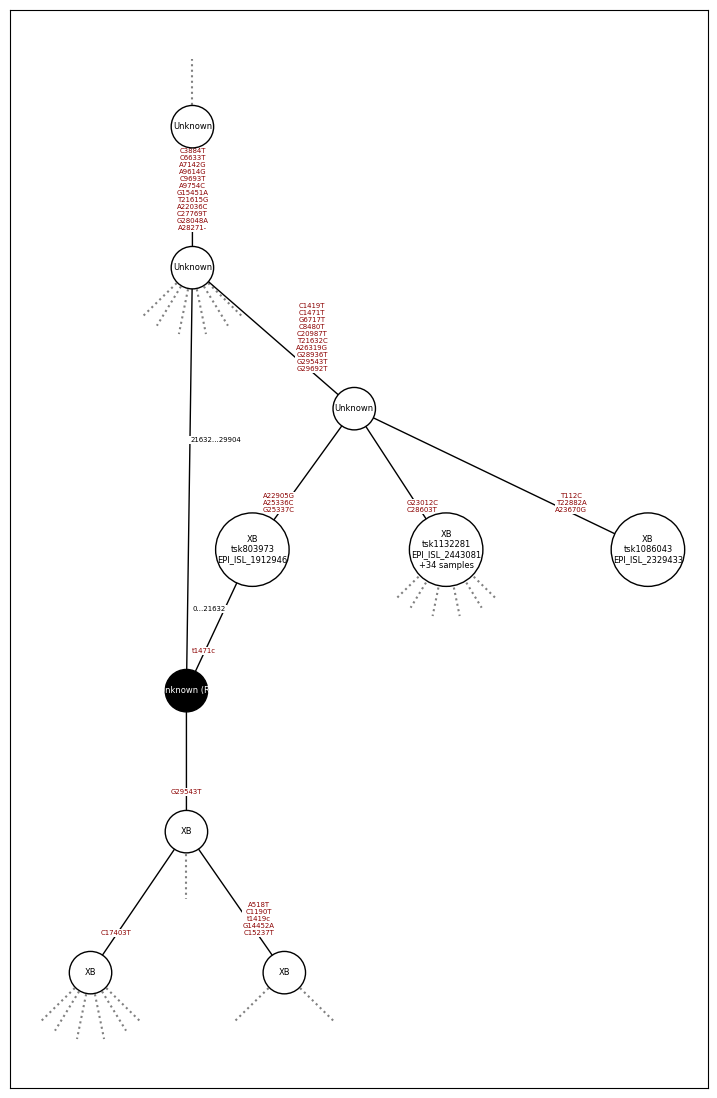

In [49]:
fig, ax = plt.subplots(figsize=(9, 14))
sc2ts.utils.plot_subgraph(focal_nodes, ts_wide, ti_wide, ax=ax)
plt.show()

### Observations

The subgraph shows that this nested XB recombinant (Wide ARG recombination node tsk964312) involves a recombination between a grandchild and its grandparent. The mutations brought in on the left hand side (regions 0..21632) are at positions 1419, 1471, 6717, 8480, and 20987, with 1471 being reverted later.

If it were possible to reposition the nodes such that 1419, 6717, 8480, and 20987 were above the tsk803973 node, this would be a removable recombination event (also note that 1419 is reverted in one of the grandchildren). This looks likely to be an artefactual recombinant.